In [1]:
%matplotlib inline
import os
from glob import glob
from astropy.io import fits

import math
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from snip import *
import SimSpec

from scipy.optimize import curve_fit

mpl.rc('font', family='serif', size=16)

In [2]:
def lowPassFilter(signal, fc, b):
    N = int(np.ceil((4 / b)))
    if not N % 2:
        N += 1
    n = np.arange(N)
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return N, np.convolve(signal, sinc_func)

def highPassFilter(signal, fc, b):
    N = int(np.ceil((4 / b)))
    if not N % 2:
        N += 1
    n = np.arange(N)
 
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    # reverse function
    sinc_func = -sinc_func
    sinc_func[(N - 1) // 2] += 1

    return N, np.convolve(signal, sinc_func)

In [3]:
dr12dir = '../sdss_dr12/'

In [4]:
snia_files = glob('grauer_SNIa/*.fits')

num_snia = len(snia_files)
print num_snia

89


424 51893 355


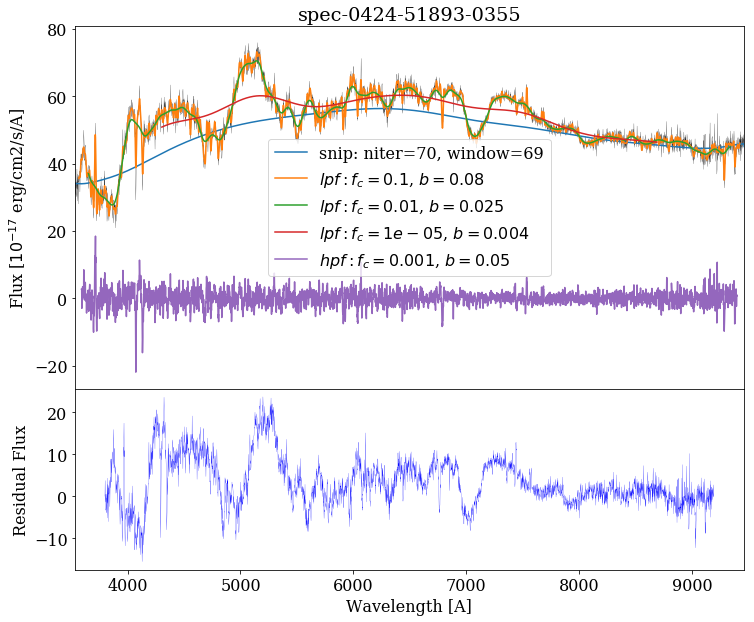

In [46]:
for snia_file in snia_files:
    
    snia_spec = fits.open(snia_file)

    mjd   = snia_spec[0].header['MJD']
    plate = snia_spec[0].header['PLATEID']
    fiber = snia_spec[0].header['FIBERID']
    ra    = snia_spec[0].header['PLUG_RA']
    dec   = snia_spec[0].header['PLUG_DEC']
    
    # dumb way to select this supernova
    if not(mjd==51893 and plate==424 and fiber==355):
        continue
    
    Halpha = snia_spec[3].data[np.where(snia_spec[3].data['LINENAME']=='H_alpha')[0]]
    Hbeta  = snia_spec[3].data[np.where(snia_spec[3].data['LINENAME']=='H_beta')[0]]
    NII    = snia_spec[3].data[np.where(snia_spec[3].data['LINENAME']=='[N_II] 6583')[0]]
    OIII   = snia_spec[3].data[np.where(snia_spec[3].data['LINENAME']=='[O_III] 5007')[0]]

    spec = snia_spec[1]

    npix = spec.header['NAXIS2']
    flux = np.array(spec.data['flux'])

    lamda1 = 10**snia_spec[0].header['COEFF0']
    dlamda = 10**snia_spec[0].header['COEFF1']
    lamda2 = 10**(snia_spec[0].header['COEFF0'] + npix*snia_spec[0].header['COEFF1'])

    wave = np.linspace(lamda1, lamda2, npix)
    
    ### Fit low/high frequency components of spectra
    
    # Using high/low pass filters
    fc1, b1 = 0.1, 0.08
    N1, lpf1 = lowPassFilter(flux, fc=fc1, b=b1)
    dN1 = (N1-1) // 2
    lpf1 = lpf1[dN1:-dN1]

    fc2, b2 = 0.01, 0.025
    N2, lpf2 = lowPassFilter(flux, fc=fc2, b=b2)
    dN2 = (N2-1) // 2
    lpf2 = lpf2[dN2:-dN2]
    
    fc3, b3 = 0.00001, 0.004
    N3, lpf3 = lowPassFilter(flux, fc=fc3, b=b3)
    dN3 = (N3-1) // 2
    lpf3 = lpf3[dN3:-dN3]
    
    fc4, b4 = 0.001, 0.05
    N4, hpf1 = highPassFilter(flux, fc=fc4, b=b4)
    dN4 = (N4-1) // 2
    hpf1 = hpf1[dN4:-dN4]
    
    # Using SNIP
#     bs = snip(flux, 56, 55)  # seems to work nicely (SYB)
#     bs = snip(flux, 70, 69)
#     residual = flux - bs

    # Plot
    from matplotlib import gridspec

#     fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10), sharex=True)
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(2,1, height_ratios=[2, 1]) 
    
    ax1 = plt.subplot(gs[0])
    ax1.plot(wave, flux, color='k', lw=0.2)
    ax1.plot(wave, bs, label='snip: niter=70, window=69')
    
    ax1.plot(wave[dN1:-dN1], lpf1[dN1:-dN1], label='$lpf: f_c={:g}$, $b={:g}$'.format(fc1, b1))
    ax1.plot(wave[dN2:-dN2], lpf2[dN2:-dN2], label='$lpf: f_c={:g}$, $b={:g}$'.format(fc2, b2))
    ax1.plot(wave[dN3:-dN3], lpf3[dN3:-dN3], label='$lpf: f_c={:g}$, $b={:g}$'.format(fc3, b3))
    ax1.plot(wave[dN4:-dN4], hpf1[dN4:-dN4], label='$hpf: f_c={:g}$, $b={:g}$'.format(fc4, b4))

    
    ax2 = plt.subplot(gs[1])
    ax2.plot(wave, residual, color='b', lw=0.2)

    ax1.set(xlabel=r'Wavelength [A]',
           ylabel=r'Flux [$10^{-17}$ erg/cm2/s/A]',
           title='spec-%04d-%d-%04d' % (plate, mjd, fiber),
           xlim=[lamda1, lamda2])
    
    ax2.set(xlabel=r'Wavelength [A]',
       ylabel=r'Residual Flux',)
  
    Halpha_line = Halpha['LINEWAVE'][0]
#     ax.axvline(Halpha_line, ls='--')
    plt.subplots_adjust(hspace=0)
    ax1.legend(loc='best')
    
    print plate, mjd, fiber
# snia_spec[1].header
    